In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

Introduction to Porekit-Python
==============================

Disclaimer
------
Porekit is the result of my personal interest in nanopore sequencing. I'm not affiliated with Oxford Nanopore Technologies, or any MAP participant. This means a lot of the factual information presented in this notebook may be wrong.

## What Oxford Nanopore Data looks like

The MinION sequencer is attached to a laptop running what I would call the "primary" sequencing tool. This program connects directly to the MinION device and tells it what to do. Optionally, third party software can connect to an API inside the primary software to remote control the sequencing process. That is not covered here, though.

In a nutshell, nanopore sequencing works by dragging a DNA molecule through a tiny pore in a membrane. As the DNA passes, the voltage difference between the two sides of the membrane change, depending on the electrochemical properties of the passing nucleotides. This means that at the core of the nanopore data there is a timeseries of voltage measurements, which is called the "squiggle".

The process to convert the squiggle into a sequence of DNA letters is called base calling. The current MinION software uploads the squiggle to Metrichor servers, which perform the base calling, and send the result back to the user's computer.

The result of a sequencing run is a collection of FAST5 files, each containing data on one molecule of DNA which passed through one of currently 512 channels in the flowcell. These files are stored on disk, usually in one directory per run. A convention seems to be to name each file with a unique and descriptive string:

In [2]:
!ls /media/internal_2/nanopore/flowcell_17/downloads | tail -n 10

LomanLabz_PC_E.coli_MG1655_ONI_3058_1_ch315_file0_strand.log
LomanLabz_PC_E.coli_MG1655_ONI_3058_1_ch315_file10_strand.fast5
LomanLabz_PC_E.coli_MG1655_ONI_3058_1_ch315_file10_strand.log
LomanLabz_PC_E.coli_MG1655_ONI_3058_1_ch315_file11_strand.fast5
LomanLabz_PC_E.coli_MG1655_ONI_3058_1_ch315_file11_strand.log
LomanLabz_PC_E.coli_MG1655_ONI_3058_1_ch315_file12_strand.fast5
LomanLabz_PC_E.coli_MG1655_ONI_3058_1_ch315_file12_strand.log
LomanLabz_PC_E.coli_MG1655_ONI_3058_1_ch315_file13_strand.fast5
LomanLabz_PC_E.coli_MG1655_ONI_3058_1_ch315_file13_strand.log
LomanLabz_PC_E.coli_MG1655_ONI_3058_1_ch315_file14_strand.fast5


These files belong to data publishd by Quick et al. http://europepmc.org/abstract/MED/25386338;jsessionid=ijHIHUVXlcpxeTzVUihz.0



## Gathering Metadata

Porekit contains functions to gather data from nanopore files. The following snippet will extract meta data from all of my downloaded nanopore data, searching directories recursively.

In [3]:
import porekit
everything = porekit.gather_metadata("/media/internal_2/nanopore")

The result is a Pandas DataFrame object, which is too big to comfortably view in its entirety, but still comparatively "small data". Here is a subset of it:

In [4]:
everything[['asic_id', 'channel_number', 'template_length', 'complement_length']].head()

,asic_id,channel_number,template_length,complement_length
filename,,,,
Cathy_016602R_2625_1_ch392_file7_strand.fast5,42984,392,927,937
Cathy_016602R_2625_1_ch347_file30_strand.fast5,42984,347,997,1034
Cathy_016602R_2625_1_ch169_file6_strand.fast5,42984,169,998,982
Cathy_016602R_2625_1_ch251_file10_strand.fast5,42984,251,969,945
Cathy_016602R_2625_1_ch48_file19_strand.fast5,42984,48,1047,992


All of the columns available:

In [5]:
everything.columns

Index(['absolute_filename', 'format', 'run_id', 'asic_id', 'version_name',
       'device_id', 'flow_cell_id', 'asic_temp', 'heatsink_temp',
       'channel_number', 'channel_range', 'channel_sampling_rate',
       'channel_digitisation', 'channel_offset', 'has_basecalling',
       'basecall_timestamp', 'basecall_version', 'basecall_name',
       'has_template', 'template_length', 'has_complement',
       'complement_length', 'has_2D', '2D_length'],
      dtype='object')

The file names are used as an index, because they are assumed to be unique and descriptive. Even when the absolute/physical location of the dataset changes, data or analytics based on these filenames are still useful.



## Grouping by Device, ASIC and Run Ids


In [6]:
g = everything.groupby(['device_id', 'asic_id', 'run_id'])

In [7]:
df = g.template_length.agg([lambda v: len(v), np.mean, np.max])
df.columns = ['Count', 'Mean template length', 'Max template_length']
df

Count  \
device_id asic_id   run_id                                            
MN02123   36544     d5c085dc93da5740a906ccfd86aad93c2f0a44c8   2907   
MN02178   42284     8c32b7dd2439ca736334403aa6cd5bb3b8db9768    326   
MN02260   42984     1e0b0295fee874d333a63f754ea2739c94963a9b    612   
MN02440   32019     4e9410f18de197eedbfb2fb8d658070636d873b8   1086   
MN02747   33477     cab43ae4f1307a1d137e3e6f333d4e2625d7df87    274   
                    e86b6d15d61cdb6fce877c83a4d5a94853dee3e5   3197   
          34496     2162cf6c92452e5299254d63b8d5d08bc238c65e  13633   
MN15177   284879449 305664a831df5a02a380b156b14d87bb62aec7eb    535   
          285402803 076a0ad0aa63f7e227b56b9fd578fee291900c73      8   
                    64e00cc05df2a142620cdf18077d7565b8cf493e    276   
                    cda984b6b52487fc369d7d5501b108248ed1a8ad    268   
                    f09ac855e11ec77155062c195e930261730752b3      1   
          84472659  de9a268a32301b52656f5f45fd905162c0d67048    625   

                                                              Mean template length  \
device_id asic_id   run_id                                                           
MN02123   36544     d5c085dc93da5740a906ccfd86aad93c2f0a44c8           5809.882222   
MN02178   42284     8c32b7dd2439ca736334403aa6cd5bb3b8db9768           1544.319018   
MN02260   42984     1e0b0295fee874d333a63f754ea2739c94963a9b           1017.441176   
MN02440   32019     4e9410f18de197eedbfb2fb8d658070636d873b8           4390.493208   
MN02747   33477     cab43ae4f1307a1d137e3e6f333d4e2625d7df87            344.881988   
                    e86b6d15d61cdb6fce877c83a4d5a94853dee3e5           1651.337186   
          34496     2162cf6c92452e5299254d63b8d5d08bc238c65e           2083.111542   
MN15177   284879449 305664a831df5a02a380b156b14d87bb62aec7eb                   NaN   
          285402803 076a0ad0aa63f7e227b56b9fd578fee291900c73                   NaN   
                    64e00cc05df2a142620cdf18077d7565b8cf493e                   NaN   
                    cda984b6b52487fc369d7d5501b108248ed1a8ad                   NaN   
                    f09ac855e11ec77155062c195e930261730752b3                   NaN   
          84472659  de9a268a32301b52656f5f45fd905162c0d67048                   NaN   

                                                              Max template_length  
device_id asic_id   run_id                                                         
MN02123   36544     d5c085dc93da5740a906ccfd86aad93c2f0a44c8                48772  
MN02178   42284     8c32b7dd2439ca736334403aa6cd5bb3b8db9768                 2505  
MN02260   42984     1e0b0295fee874d333a63f754ea2739c94963a9b                 2387  
MN02440   32019     4e9410f18de197eedbfb2fb8d658070636d873b8                25475  
MN02747   33477     cab43ae4f1307a1d137e3e6f333d4e2625d7df87                 6700  
                    e86b6d15d61cdb6fce877c83a4d5a94853dee3e5                24731  
          34496     2162cf6c92452e5299254d63b8d5d08bc238c65e                30245  
MN15177   284879449 305664a831df5a02a380b156b14d87bb62aec7eb                  NaN  
          285402803 076a0ad0aa63f7e227b56b9fd578fee291900c73                  NaN  
                    64e00cc05df2a142620cdf18077d7565b8cf493e                  NaN  
                    cda984b6b52487fc369d7d5501b108248ed1a8ad                  NaN  
                    f09ac855e11ec77155062c195e930261730752b3                  NaN  
          84472659  de9a268a32301b52656f5f45fd905162c0d67048                  NaN


As you can see, I have downloaded several nanopore sets from ENA. These are mostly incomplete sets, since I was interested more in the variety of data rather than the completeness. You can easily use `wget` to download a tarball from ENA, then extract the partial download. The last file will be truncated, but the rest is usable.

## Analyzing a single run


The following refers to a dataset submitted by "Virginia Commonwealth University". I don't believe there is a publication associated with it yet. http://www.ebi.ac.uk/ena/data/view/ERP009740

In [8]:
vcu = porekit.gather_metadata("/media/internal_2/nanopore/vcu/Users/blbrown/Documents/DATA/Biology Stuff/")

This is actually several runs of data:

In [9]:
vcu.groupby(['run_id']).run_id.count()

run_id
2162cf6c92452e5299254d63b8d5d08bc238c65e    13633
cab43ae4f1307a1d137e3e6f333d4e2625d7df87      274
e86b6d15d61cdb6fce877c83a4d5a94853dee3e5     3197
Name: run_id, dtype: int64

Let's select just the first read:

In [10]:
vcu = vcu [vcu.run_id == '2162cf6c92452e5299254d63b8d5d08bc238c65e']
vcu.run_id.unique()

array(['2162cf6c92452e5299254d63b8d5d08bc238c65e'], dtype=object)

The current library prep puts a hairpin protein on one end of a double stranded DNA molecule. First one strand passes the nanopore, then the hairpin, then the complement. Because biochemistry is messy, some molecules don't have a hairpin, some templates are much shorter than the complement, or the other way around.

In the best case though, the read contains both a template and a complement, which can be aligned to improve the overall quality of the read. This is then called a "2D read".

In [11]:
vcu.template_length.describe()

count     9028.000000
mean      2083.111542
std       3380.791174
min          7.000000
25%        123.000000
50%        244.000000
75%       3105.000000
max      30245.000000
Name: template_length, dtype: float64

In [12]:
vcu.complement_length.describe()

count     3496.000000
mean      2735.812929
std       3495.886600
min         15.000000
25%        134.000000
50%        494.000000
75%       5197.250000
max      25290.000000
Name: complement_length, dtype: float64

In [13]:
vcu['2D_length'].describe()

count     1619.000000
mean      5504.660902
std       3664.274453
min        205.000000
25%       2256.000000
50%       5444.000000
75%       7937.500000
max      23342.000000
Name: 2D_length, dtype: float64

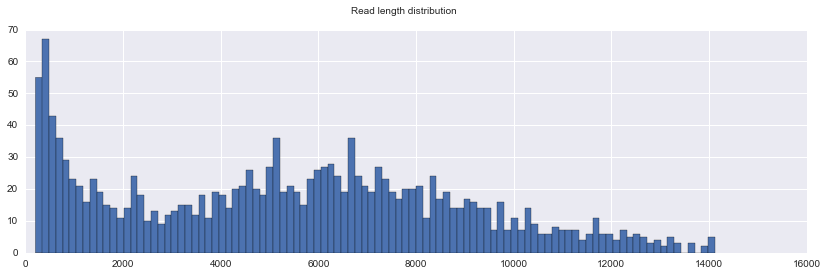

In [14]:
f, ax = plt.subplots()
f.set_figwidth(14); f.set_figheight(4)
f.suptitle("Read length distribution")
sub = vcu[vcu.has_2D]
max_length = np.percentile(sub['2D_length'], 99)
sub = sub[sub['2D_length']< max_length]
ax.hist(sub['2D_length'], bins=100);

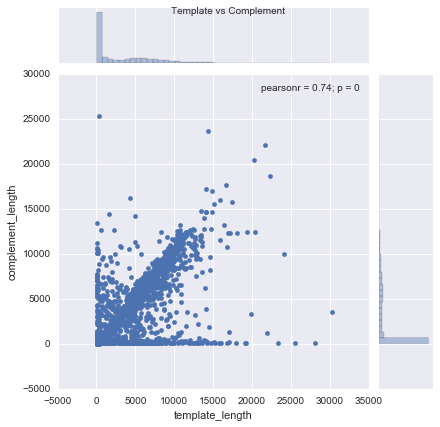

In [15]:
sub = vcu[vcu.has_template & vcu.has_complement]
plt = sb.jointplot(sub['template_length'],sub['complement_length'])
plt.fig.suptitle("Template vs Complement");